## Train on certain amount of time, predict future states

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

from sparseRRR import relaxed_elastic_rrr, bibiplot
from sklearn.exceptions import ConvergenceWarning

### Load and split data

I feel like this leaks information from training set into test set, so let us not preprocess like this for now.

In [54]:
def preprocess(data):
    X = data['Firing rate']
    #X = X - np.mean(X, axis=0)
    #X = X / np.std(X, axis=0)

    Y = data['Locomotion']
    #Y = Y - np.mean(Y, axis=0)
    #Y = Y / np.std(Y, axis=0)
    
    return X,Y

In [55]:
data = pickle.load(open('../data/purkinje.pickle', 'rb'))

X,Y = preprocess(data)
cell_names = data['cell_names']
locomotion_names = data['locomotion_names']

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (2691968, 105) 
Shape of Y: (2691968, 4)


It is a lot of timepoints, so let us play around with reduced data set sizes.

In [56]:
tr_slice = np.linspace(0, 100000, 100000, dtype=int)
tr_slice

array([     0,      1,      2, ...,  99997,  99998, 100000])

In [32]:
test_slice = np.linspace(100001, 110000, 9999, dtype=int)
test_slice

array([100001, 100002, 100003, ..., 109997, 109998, 110000])

In [33]:
X_train = X[tr_slice, :]
Y_train = Y[tr_slice, :]
X_test = X[test_slice, :]
Y_test = Y[test_slice, :]

### Preprocess

In [34]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
Y_train_mean = Y_train.mean(axis=0)
Y_train_std = Y_train.std(axis=0)

# Z_score with training mean and std
X_train = (X_train - X_train_mean) / X_train_std
Y_train = (Y_train - Y_train_mean) / Y_train_std
X_test = (X_test - X_train_mean) / X_train_std
Y_test = (Y_test - Y_train_mean) / Y_train_std

### Train and predict

In [35]:
w,v = relaxed_elastic_rrr(X_train, Y_train, rank=2, alpha=.34, l1_ratio=1)

print('\nNeurons selected: {}'.format(np.sum(w[:,0]!=0)))
print(cell_names[w[:,0]!=0])


Neurons selected: 10
[b'MC3808_S2' b'MC4017_S2' b'MC5003_S14' b'MC5003_S21' b'MC5003_S25'
 b'MC5003_S28' b'MC5005_S5' b'MC5005_S6' b'MC5005_S8' b'MC6001_S5']


In [36]:
tr_R2 = 1-np.sum((Y_train - X_train@ w @ v.T)**2)/np.sum(Y_train**2)
print('\nTraining R2: {}'.format(tr_R2))


Training R2: 0.603434873890015


In [37]:
# should be the same
tr_R2 = 1-np.mean((Y_train - X_train @ w @ v.T)**2)/np.var(Y_train)
print('\nTraining R2: {}'.format(tr_R2))


Training R2: 0.6034348738900148


In [38]:
test_R2 = 1-np.sum((Y_test - X_test @ w @ v.T)**2)/np.sum((Y_test-Y_test.mean(axis=0))**2)
print('\nTest R2: {}'.format(test_R2))


Test R2: 0.5617179924460542


In [39]:
# I think the former is more correct
test_R2 = 1-np.mean((Y_test - X_test @ w @ v.T)**2)/np.var(Y_test)
print('\nTest R2: {}'.format(test_R2))


Test R2: 0.5623796657595408


In [58]:
# Everything else:
test_R2 = 1-np.sum(((Y[100001:, :]-Y_train_mean)/Y_train_std - (X[100001:, :]-X_train_mean)/X_train_std @ w @ v.T)**2)/np.sum(((Y[100001:, :]-Y_train_mean)/Y_train_std-((Y[100001:, :]-Y_train_mean)/Y_train_std).mean(axis=0))**2)
print('\nTest R2: {}'.format(test_R2))


Test R2: 0.27126714295391086


### Some visualizations

Text(0.5, 1.0, 'Sorted row l2-norms of $W$')

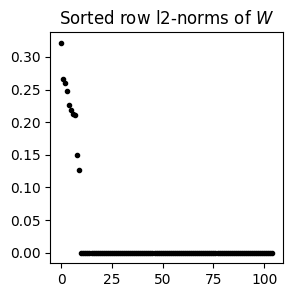

In [40]:
# Row l2-norms of W
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(np.sort(np.linalg.norm(w, axis=1))[::-1], '.', color='black')
ax.set_title(r'Sorted row l2-norms of $W$')

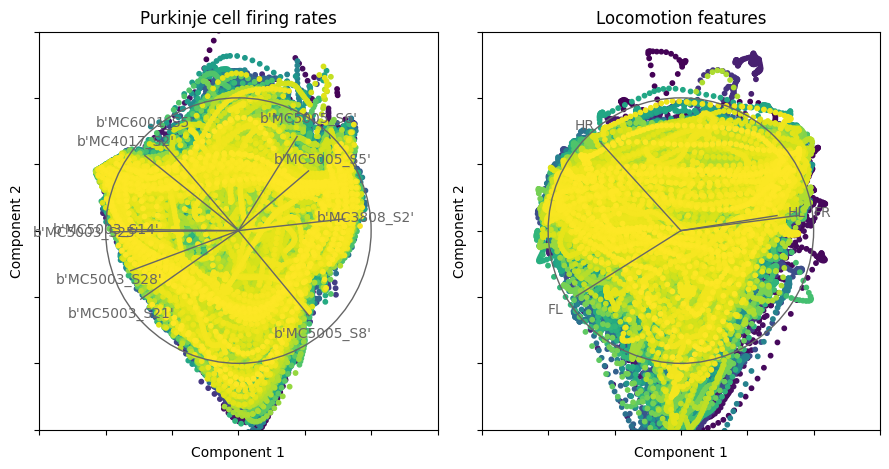

In [41]:
# Training data latent activations
bibiplot(X_train, Y_train, w, v, 
         titles = ['Purkinje cell firing rates', 'Locomotion features'],
         YdimsNames = locomotion_names, 
         XdimsNames = cell_names
         )

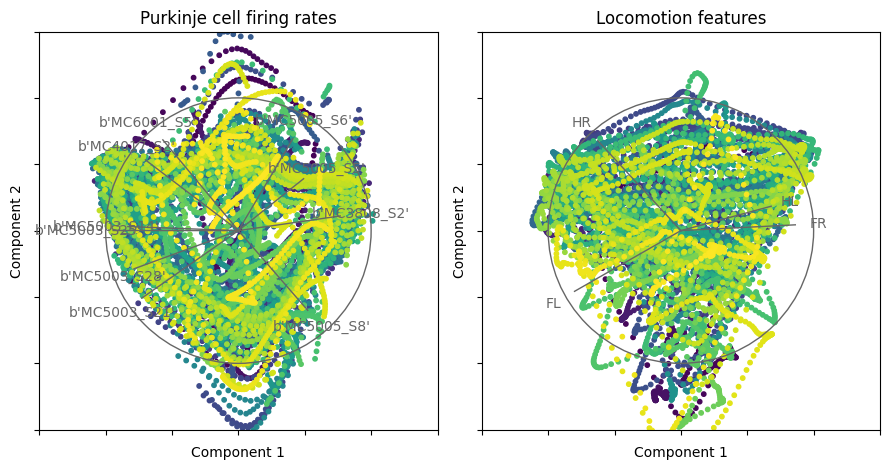

In [42]:
# Test data latent activations
bibiplot(X_test, Y_test, w, v, 
         titles = ['Purkinje cell firing rates', 'Locomotion features'],
         YdimsNames = locomotion_names, 
         XdimsNames = cell_names
         )

### Slightly degrading test R^2 over time

In [45]:
test_slice

array([100001, 100002, 100003, ..., 109997, 109998, 110000])

In [46]:
test_slice.shape

(9999,)

In [47]:
np.linspace(0,test_slice.shape[0],test_slice.shape[0], dtype=int)

array([   0,    1,    2, ..., 9996, 9997, 9999])

In [50]:
test_R2s = []
for tp in np.linspace(0,test_slice.shape[0],test_slice.shape[0], dtype=int)[1000:][::100]:
    test_R2s.append(
        1-np.sum((Y_test[:tp,:] - X_test[:tp,:] @ w @ v.T)**2)/np.sum((Y_test[:tp,:]-Y_test[:tp,:].mean(axis=0))**2)
    )

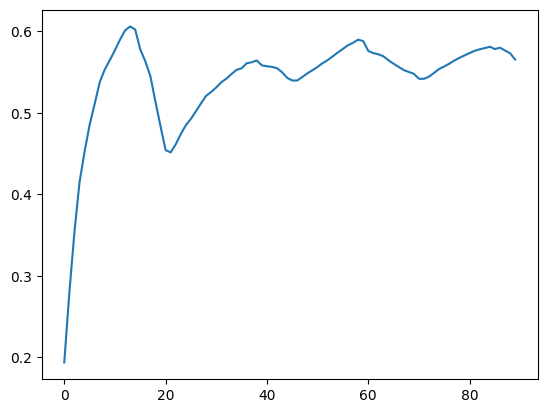

In [52]:
plt.plot(test_R2s)